# Implémentation de l'algorithme APS

### Introduction
Ce notebook implémente la méthode **APS (Adaptive Prediction Sets)** pour la classification des types de forêts.

Contrairement à la méthode SCP standard qui applique un seuil de probabilité fixe (ex: "garder toutes les classes > 10%"), l'APS adopte une approche locale et adaptative. Au lieu de regarder la valeur brute de probabilité, l'APS s'intéresse à la masse de probabilité cumulée.

L'intuition est celle d'un "remplissage de seau" : pour chaque observation, on accumule les classes de la plus probable à la moins probable jusqu'à atteindre un niveau de confiance total (par exemple 95%).

### Pourquoi l'APS ?

La méthode SCP standard souffre de deux défauts majeurs :

1. **Ensembles vides** : Si le modèle est très incertain (ex: probabilités 0.15, 0.14, 0.13...), aucune classe ne dépasse le seuil fixe, et le modèle ne renvoie rien.
2. **Manque d'adaptivité** : Elle traite les cas "faciles" et "difficiles" avec la même rigueur, ce qui conduit souvent à des ensembles trop grands pour les cas faciles ou trop petits pour les cas difficiles.

L'APS résout ces problèmes en garantissant que l'ensemble s'agrandit automatiquement lorsque le modèle est incertain (pour accumuler assez de probabilité) et rétrécit lorsqu'il est confiant.

### Mise en place

1. **Séparation des données** : Entraînement, Calibration, Test.
2. **Entraînement** : Un classifieur estime les probabilités $\hat{\pi}(y|x)$ pour chaque classe.
3. **Calibration** :
    - Pour chaque point de calibration, on trie les classes par probabilité décroissante.
    - On calcule le score de non-conformité : c'est la probabilité cumulée qu'il a fallu sommer pour atteindre la vraie classe.
    - On détermine le quantile $\hat{q}$ (ex: 95%) de ces scores.
4. **Construction des ensembles** :
    - Pour un nouveau point, on trie les classes prédites.
    - On ajoute les classes dans l'ensemble tant que leur somme cumulée ne dépasse pas $\hat{q}$.
5. **Évaluation** : On vérifie la couverture (le taux de présence de la vraie classe) et la cardinalité moyenne (taille des ensembles).

### Chargement des données

In [ ]:
import numpy as np
import polars as pl

# Polars display options
pl.Config.set_tbl_hide_column_data_types(True)
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(2)

# Load preprocessed data
df = pl.read_parquet("../../data/forest_cover_clean.parquet")

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (581012, 13)


Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,_Soil_Type,_Wilderness_Area
2596,51,3,258,0,510,221,232,148,6279,5,"""28""","""0"""
2590,56,2,212,-6,390,220,235,151,6225,5,"""28""","""0"""
2804,139,9,268,65,3180,234,238,135,6121,2,"""11""","""0"""
2785,155,18,242,118,3090,238,238,122,6211,2,"""29""","""0"""
2595,45,2,153,-1,391,220,234,150,6172,5,"""28""","""0"""


### Séparation des données

In [26]:
from sklearn.model_selection import train_test_split

y = df.drop_in_place("Cover_Type")
X = df

# 60% train, 20% calibration, 20% test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train set size (60%): {X_train.shape[0]}")
print(f"Calibration set size (20%): {X_calib.shape[0]}")
print(f"Test set size (20%): {X_test.shape[0]}")

Train set size (60%): 348607
Calibration set size (20%): 116202
Test set size (20%): 116203


### Définition du modèle

Au regard de la taille du dataset et du temps de fit, nous n'allons pas optimiser les hyperparamètres.

In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.1,
    max_iter=2000,
    max_depth=None,
    max_leaf_nodes=127,
    min_samples_leaf=50,
    l2_regularization=0.5,
    categorical_features="from_dtype",
    early_stopping=True,
    n_iter_no_change=20,
    validation_fraction=0.1,
    class_weight="balanced",  # Covertype classes are heavily imbalanced
    random_state=42,
)

model.fit(X_train, y_train);

### Évaluation du modèle de base

In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      0.94      0.94     42218
           2       0.96      0.94      0.95     56895
           3       0.95      0.96      0.96      7075
           4       0.88      0.89      0.88       536
           5       0.81      0.94      0.87      1933
           6       0.89      0.96      0.92      3449
           7       0.95      0.98      0.96      4097

    accuracy                           0.94    116203
   macro avg       0.91      0.94      0.93    116203
weighted avg       0.94      0.94      0.94    116203



### Adaptive Prediction Sets (APS)

La méthode APS repose sur le classement des probabilités. Pour chaque observation, le score de non-conformité est défini comme la masse de probabilité cumulée nécessaire pour atteindre la vraie classe.

$s_i = \sum_{k \in \mathcal{Y}} \hat{\pi}(k|x_i) \cdot \mathbb{I}[\hat{\pi}(k|x_i) \ge \hat{\pi}(y_i|x_i)]$

En termes simples : on trie les probabilités de la plus grande à la plus petite, et on somme jusqu'à trouver la vraie classe.

In [29]:
# 1. Predict probabilities on calibration set
y_calib_pred_proba = model.predict_proba(X_calib)
classes = model.classes_

# Helper to get sorting indices (descending probability)
# argsort returns indices that sort the array, we flip specifically for descending
sorted_indices = np.argsort(y_calib_pred_proba, axis=1)[:, ::-1]

# Sort the probabilities
sorted_probas = np.take_along_axis(y_calib_pred_proba, sorted_indices, axis=1)

# Compute cumulative probabilities
cum_probas = np.cumsum(sorted_probas, axis=1)

# 2. Compute nonconformity scores (Cumulative probability of true class)

# Map class names to indices
class_to_idx = {c: i for i, c in enumerate(classes)}
y_calib_indices = np.array([class_to_idx[yi] for yi in y_calib])

# Find the rank of the true class for each sample
# We compare the sorted indices to the true class index
# np.where returns (row_indices, rank_indices)
rows, ranks = np.where(sorted_indices == y_calib_indices[:, None])

# The score is the cumulative probability at the rank of the true class
nonconformity_scores = cum_probas[rows, ranks]

In [30]:
# 3. Compute quantile
alpha = 0.01
target_coverage = 1 - alpha
n = len(nonconformity_scores)
q_level = np.ceil((n + 1) * (1 - alpha)) / n
qhat = np.quantile(nonconformity_scores, q_level, method="linear")

f"APS calibration qhat (α={alpha}): {qhat:.6f}"

'APS calibration qhat (α=0.01): 0.999988'

### Distribution des scores de non-conformité

Contrairement à la SCP où le score est une probabilité simple, ici le score représente une masse cumulée. Si le score est faible, cela signifie que la vraie classe était parmi les plus probables. Si le score est proche de 1, le modèle a classé la vraie classe comme très improbable.

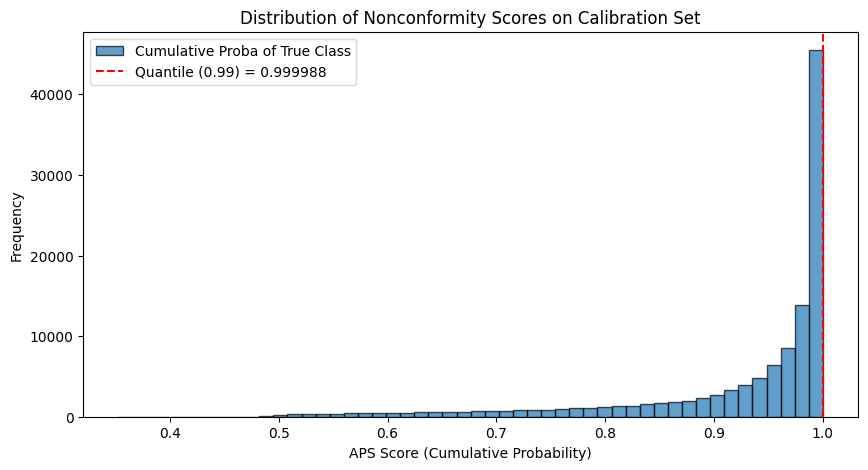

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(
    nonconformity_scores,
    bins=50,
    alpha=0.7,
    edgecolor="k",
    label="Cumulative Proba of True Class",
)
plt.axvline(
    qhat, color="red", linestyle="--", label=f"Quantile ({1 - alpha:.2f}) = {qhat:.6f}"
)
plt.xlabel("APS Score (Cumulative Probability)")
plt.ylabel("Frequency")
plt.title("Distribution of Nonconformity Scores on Calibration Set")
plt.legend()
plt.show()

Ce graphique suggère que le modèle est bien calibré et montre des performances excellentes sur le jeu de calibration.

### Construction des ensembles de prédiction

Pour l'ensemble de test, nous répétons le processus :
1. Prédire et trier les probabilités.
2. Calculer la somme cumulée.
3. Inclure toutes les classes tant que la somme cumulée est inférieure à $\hat{q}$.

In [ ]:
# 4. Predict on test set
y_test_pred_proba = model.predict_proba(X_test)

# Sort probabilities (descending)
test_sorted_indices = np.argsort(y_test_pred_proba, axis=1)[:, ::-1]
test_sorted_probas = np.take_along_axis(y_test_pred_proba, test_sorted_indices, axis=1)
test_cum_probas = np.cumsum(test_sorted_probas, axis=1)

# 5. Build prediction sets
prediction_sets = []

for i in range(len(X_test)):
    # Find indices where cumulative proba is <= qhat
    # We must include the first class that crosses the threshold to ensure coverage
    # Logical trick: include class if the *previous* cumulative sum was < qhat
    # Or simply: take all classes where cum_probas <= qhat, plus the first one that exceeds it.

    # Identify which ranks are inside the quantile
    mask = test_cum_probas[i] <= qhat

    # If the first class is already > qhat, we must minimally include the top-1 class
    # Otherwise, we might get an empty set if qhat is very small (though unlikely with alpha=0.01)
    if not np.any(mask):
        included_ranks = np.array([0])  # Keep at least top 1
    else:
        # Get indices of True values
        true_indices = np.where(mask)[0]
        last_idx = true_indices[-1]

        # We generally include the one that crosses the boundary to be safe
        # (Though strictly it depends on exact definition, usually include boundary)
        included_ranks = (
            np.arange(last_idx + 1)  # +1 to include 0 to last_idx
            if last_idx < len(classes) - 1
            else np.arange(len(classes))
        )

    # Map back sorted ranks to original class names
    original_indices = test_sorted_indices[i, included_ranks]
    pset = classes[original_indices].tolist()
    prediction_sets.append(pset)

# Create results DataFrame
df_test_results = pl.DataFrame(
    {
        "True Class": y_test,
        "Prediction Set": prediction_sets,
    }
).with_columns(pl.col("Prediction Set").list.len().alias("Cardinality"))

# Add features for analysis
df_test_full = pl.concat([df_test_results, X_test], how="horizontal")
df_test_full.head()

True Class,Prediction Set,Cardinality,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,_Soil_Type,_Wilderness_Area
1,[1],1,2844,317,29,127,69,3792,131,200,202,5711,"""28""","""0"""
1,[1],1,3037,304,16,0,0,2955,175,230,195,1736,"""23""","""2"""
2,"[2, 5, … 6]",5,2727,213,18,95,23,768,201,254,184,2068,"""3""","""2"""
2,"[2, 1, … 6]",4,2854,117,6,90,20,1295,231,234,136,2424,"""30""","""2"""
2,"[2, 5, … 6]",4,2554,348,13,0,0,1593,194,217,161,4569,"""15""","""0"""


### Évaluation des performances

In [33]:
df_test_full.describe()

statistic,True Class,Prediction Set,Cardinality,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,_Soil_Type,_Wilderness_Area
"""count""",116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,116203.00,"""116203""","""116203"""
"""null_count""",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"""0""","""0"""
"""mean""",2.05,null,2.20,2959.91,155.80,14.11,269.43,46.28,2348.02,212.17,223.37,142.53,1979.56,null,null
"""std""",1.40,null,1.00,279.18,111.83,7.49,212.76,58.22,1556.16,26.74,19.78,38.37,1320.56,null,null
"""min""",1.00,null,1.00,1863.00,0.00,0.00,0.00,-173.00,0.00,0.00,0.00,0.00,0.00,null,null
"""25%""",1.00,null,1.00,2809.00,59.00,9.00,108.00,7.00,1110.00,198.00,213.00,119.00,1024.00,null,null
"""50%""",2.00,null,2.00,2996.00,127.00,13.00,218.00,30.00,1998.00,218.00,226.00,143.00,1712.00,null,null
"""75%""",2.00,null,3.00,3164.00,260.00,18.00,384.00,69.00,3314.00,231.00,237.00,168.00,2551.00,null,null
"""max""",7.00,null,6.00,3856.00,360.00,62.00,1383.00,598.00,7061.00,254.00,254.00,252.00,7145.00,null,null


### Définition des métriques de performances

In [34]:
coverage = (
    pl.col("Prediction Set")
    .list.contains(pl.col("True Class"))
    .mean()
    .mul(100)
    .round(2)
    .alias("Coverage")
)
avg_set_size = pl.col("Cardinality").mean().round(2).alias("Average Cardinality")
singleton_rate = (pl.col("Cardinality") == 1).mean().round(2).alias("Singleton Rate")

print(f"Coverage: {df_test_full.select(coverage).item()}% (target: 99%)")
print(f"Average Cardinality: {df_test_full.select(avg_set_size).item()} elements")
print(f"Singleton Rate: {df_test_full.select(singleton_rate).item()}%")

Coverage: 99.17% (target: 99%)
Average Cardinality: 2.2 elements
Singleton Rate: 0.26%


### Analyse de la couverture par classe

In [35]:
df_test_full.group_by("True Class").agg(
    coverage,
    avg_set_size,
    singleton_rate,
    pl.len().alias("Count"),
).sort("True Class")

True Class,Coverage,Average Cardinality,Singleton Rate,Count
1,99.05,1.92,0.29,42218
2,99.05,2.34,0.26,56895
3,99.99,2.74,0.07,7075
4,99.63,1.88,0.50,536
5,99.90,2.58,0.08,1933
6,99.94,2.78,0.02,3449
7,99.61,1.56,0.47,4097


### Analyse de la couverture par taille d'ensemble

In [36]:
df_test_full.group_by("Cardinality").agg(
    coverage,
    pl.len().alias("Count"),
).sort("Cardinality")

Cardinality,Coverage,Count
1,96.94,29969
2,99.92,50840
3,99.99,18931
4,99.99,15090
5,100.00,1332
6,100.00,41


### Conclusion

L'APS a tendance à générer des ensembles de tailles plus variables que la SCP, car elle s'adapte à l'incertitude locale.

On constate que l'adaptivité de l'APS permet une meilleure homogénéité de la couverture entre les classes (notamment les classes minoritaires ou difficiles).

En observant la taille moyenne des ensembles par classe, on remarque que l'algorithme "paie" le prix de l'incertitude : les classes les plus difficiles à prédire (où le modèle hésite) auront des ensembles de prédiction significativement plus grands, tandis que les classes faciles auront des ensembles très petits (proche de 1).